In [27]:
import numpy as np   #importing libraries
import simpy 
import queue
import sys
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from collections import deque
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import random
import uuid
import random as rd
import matplotlib 
from matplotlib import pyplot as plt

#rd.seed(2)

In [15]:
global SZ,CP,RM
SZ=[]
CP=[]
RM=[]
N=1000
k=10000
C=5
state=[]
#Lambda = 10
#mu = 1.5
alpha = 0.3
gamma = 0.95
#t = 0   #system clock
t1=0
t2=0
t_lambda = 0 #poisson random variable used to generate next service time
t_mu = 0  #poisson random variable used to generate next departure time
t_a=0
wait=0
R=100

transmission_time=0
l="0"
P_transmission=500
P_idle=100

episodes = 10
SHOW_EVERY = 100
STATS_EVERY=100

Q_dict=dict()
L=[]

action_list=()

In [16]:
class Packet(object):
    def __init__(self, time, id, mobileID, seeed):
        
        self.time=time                                                
        self.id=id
        self.mobileID=mobileID   
        self.size=random.randint(200,400) #seed 1 op 2, seed 2 op 
        SZ.append(round(self.size,2))
        self.cpucycle=random.uniform(100,1900)
        self.memory_need=random.uniform(1000,2000)
        self.ram=random.randint(1, 32) #seed 1 op 3, seed 2 op 1, seed 3 op 4
        RM.append(round(self.ram,2))

class mobile(object): #mobile class with an ID              
    def __init__(self, ID):
        self.ID=ID
        self.pot=int(1)
        
    #generates packets and sends via out_pipe
    def packet_generator_initial(self, numPackets, env, out_pipe, task_id,send): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
    def packet_generator(self, numPackets, env, out_pipe, task_id,send,pipe4,currentpipe): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
        state=yield pipe4.get()
        yield currentpipe.put(state)



In [17]:
 def reward_generator(T,cpu,bw,m,cost):
    cpuU=cpu*0.5
    mU=m*0.5
    bwU=bw*0.3
    
    cpusla=680
    bwsla=305
    msla=1000
    Tsla1=1.5
    Tsla2=3
    
    Ct1=0
    ct2=0
    Cp=0
    Cbw=0
    Cm=0
    

    
    #if (G<Gsla):
        #Cg=-5*(Gsla/G)
    if (cpuU<cpusla):
        Cp=-5* (cpusla/cpuU)
    if (mU<msla):
        Cm=-4* (msla/mU)
    if (bwU<bwsla):
        Cbw=-4* (bwsla/bwU)
    if (T>Tsla1 and T<Tsla2):
        Ct1 = -5 * (T/Tsla1)
        rt=(Tsla1/T) + Ct1
    elif (T>=Tsla2):
        Ct2 = -6 * (T/Tsla2)
        rt=(Tsla2/T) + Ct2
    else:
        rt=(Tsla1/T)
        
    if (cost==2):
        costp=-1*cost
    else:
        costp=0
    #if (N>Nsla):
        #Cn=-5*(N/Nsla)
    #if (cost>Cost_sla):
        #Cost_n=-5*(cost/Cost_sla)
    ru=(cpuU/cpusla)+Cp+(bwU/bwsla)+Cbw+(mU/msla)+Cm
    Reward = rt + ru + costp  #Reward Function
    return Reward

In [18]:
class Fog(object):      
    def __init__(self, ID):
        self.ID=ID
        self.cpuspeed=0
        self.cpucycle=0
        self.memory=0
        self.R=0
        self.Number_queue=0
        self.lost=0
        self.transmission_time=0
        self.response_time=0
        self.server_count=0
        self.wait=0
        self.taskinqueue=0
        self.a=0
        self.time=0
        self.neighbour1=None
        self.neighbour2=None
        
        self.service_time=[]
        self.response_time_list=[]
        self.response_time_list2=[]
        self.Serverqueue=[]
        self.total_serverqueue=[]
        self.waitlist=[]
        self.energy_offloading=[]
        self.reward_list=[]
        self.state=[]
        self.observation_space_discretesize = [11, 11, 2]
        self.q_table = np.random.uniform(low=0, high=0, size=(self.observation_space_discretesize))
    
        
    def Neighbour(self,neighbour1,neighbour2):
        self.neighbour1=neighbour1
        self.neighbour2=neighbour2

    def Calculate_Q_value(self,prevoius_state,next_state,reward):

      val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8],prevoius_state[9],prevoius_state[10],prevoius_state[11]),prevoius_state[12]))
      nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),0))
      nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),1))
      nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),2))
    
#       val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3]))
#       nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2]),0))
#       nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2]),1))
#       nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2]),2))
        
      
      if nxt_val_1==None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=0
      elif nxt_val_1==None and nxt_val_2==None and nxt_val_3!=None:
          nxt_val=nxt_val_3
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3==None:
          nxt_val=nxt_val_2
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=nxt_val_1
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3==None:
          if nxt_val_1>=nxt_val_2:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_2
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_2 and nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          elif nxt_val_2>nxt_val_1 and nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          elif nxt_val_3>nxt_val_1 and nxt_val_3>nxt_val_2:
              nxt_val=nxt_val_3
      
      if val==None:
          val=0
     
                      
      target=reward+gamma*nxt_val
      
      Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8],prevoius_state[9],prevoius_state[10],prevoius_state[11]),prevoius_state[12])]=val+alpha*(target-val)
      #Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3])]=val+alpha*(target-val)  
    
    def FOG(self, env, server, in_pipe,mobile,pipe4):
        
         msg = yield in_pipe.get()
         self.cpuspeed=random.uniform(1000,1500)
         self.memory=random.uniform(3000,4000)
         #print("FOg",self.ID,"cPU",self.cpuspeed)
         self.R=random.uniform(900,1100)
        
         state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.memory,self.neighbour1.memory,self.neighbour2.memory,self.ID,msg.id])   # CURRENT STATE for calaculatin Q VALU
         #state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.ID,msg.id])  
        
         discrete_state=()
         discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue,self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.memory,self.neighbour1.memory,self.neighbour2.memory)
         #discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue)
        
         yield pipe4.put(discrete_state) # CURRENT STATE
            
         self.transmission_time = (msg.size/self.R)
         #print("transmits task {} to need time {}".format(msg.id,transmission_time,self.ID))
         yield env.timeout(self.transmission_time)
         a=env.now
         #print("Arrived task {} at time {} at FOG {} from mobile {}".format(msg.id,a,self.ID,mobile))
         #print("server",self.server_count)
         #print("present q",self.taskinqueue)

         if self.server_count==C:
            if len(self.Serverqueue)<k:
               self.Serverqueue.append(msg)
               self.taskinqueue=len(self.Serverqueue)
               #print("queue te ase ",len(self.Serverqueue))
               #print("task ase queue te ase ",taskinqueue)
               self.Number_queue = self.Number_queue + 1
               #self.server_count=0
            else:
                 self.lost=self.lost+1
#                 cloud_transmission_time = (msg.size/R)
#                 cloud_cpuspeed=random.uniform(2000,2500)
#                 cloud_t_mu=msg.cpucycle/cloud_cpuspeed
#                 self.service_time.append(cloud_t_mu)
#                 #delay=random.uniform(3,6)
#                 delay=5
#                 self.response_time2=self.transmission_time+cloud_transmission_time+cloud_t_mu+delay
#                 self.response_time_list2.append(self.response_time2)
                
                 cost=2
                
                 #r=reward_generator(3,self.cpuspeed,self.R,self.memory,cost)
                 #self.reward_list.append(r)
            
                 new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.memory,self.neighbour1.memory,self.neighbour2.memory]
                 #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
                 #for i in state:
                  #   if i[13]==msg.id:
                     #if i[4]==msg.id:
                   #      self.Calculate_Q_value(i,new_state,r)
                    #     break

                 return  

        
#          u=rd.random()
#          t_mu=-np.log(u)/mu
#          self.service_time.append(t_mu)
#          #print("service time",t_mu)
         self.memory=self.memory-msg.memory_need   
         t_mu=msg.cpucycle/self.cpuspeed
         self.service_time.append(t_mu)
         #print(t_mu)
         
         E = (P_transmission * self.transmission_time) + (P_idle * t_mu)
         self.energy_offloading.append(E)
         
         #print("present a queue te ase ",len(self.Serverqueue))
         #print("Fog:   Fog",self.ID,"mobile",mobile,", akhon queue te ase ",self.taskinqueue,", time",env.now)

         with server.request() as req:
             yield req
             s=env.now
             self.wait=s-a
             if len(self.Serverqueue)>0:
                 self.Serverqueue.pop(0)
             #self.total_serverqueue.append(len(self.Serverqueue))
             #print("queue",len(self.Serverqueue))
             #print("wait",self.wait)
             #print("Starting service task {} at time {} at FOG {}".format(msg.id,s,self.ID))
             #print("Waiting time of task {} at time {} at FOG {}".format(msg.id,self.wait,self.ID))
             self.waitlist.append(self.wait)
             self.response_time=self.wait+t_mu+self.transmission_time
             self.response_time_list.append(self.response_time)
             
             self.server_count=self.server_count+1
             yield env.timeout(t_mu)
             #print("Finish service task {} at time {} at FOG {}".format(msg.id,env.now,self.ID))
             self.server_count=self.server_count-1   
            
             cost=0
             r=reward_generator(self.response_time,self.cpuspeed,self.R,self.memory,cost)
             self.reward_list.append(r)
             #print("r",r)
            
             new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.memory,self.neighbour1.memory,self.neighbour2.memory]
             #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
             for i in state:
               if i[13]==msg.id:
               #if i[4]==msg.id:
                 self.Calculate_Q_value(i,new_state,r)
        
                 break
                

        

In [19]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.t5=0
        self.t6=0
        self.statetime=0
        self.current=()
    def decision(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1           
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                 #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,0,statepipe))
                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t3+t_lambda
            self.t3=t_a
            env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t5+t_lambda
#             self.t5=t_a
#             env1.process(ms5.packet_generator(1, env1, pipe6, i,t_a,pipe4,currentpipe))
    
    
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t6+t_lambda
#             self.t6=t_a
#             env1.process(ms6.packet_generator(1, env1, pipe7, i,t_a,pipe4,currentpipe))

            current2=yield currentpipe.get()
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            # action=random.randint(0,2)
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
#                              #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                    
                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))

 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

####################################second mobile 333333333333333333333333

            current2=yield currentpipe.get()
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            if(action==0):
                    
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
#                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog1_count=self.fog1_count+1
                             env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                              #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                    
                            
            if(action==1):
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))

 
            if(action==2):
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

####################################third mobile 333333333333333333333333

            current2=yield currentpipe.get()
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            if(action==0):
                    
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
#                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                             self.fog1_count=self.fog1_count+1
                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                    
                            
            if(action==1):
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))

 
            if(action==2):
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))     

#################################### fourth mobile 333333333333333333333333
#             current2=yield currentpipe.get()
#             #print("time, current state, i: ",env1.now,current2,i)
            
#             action1=Q_dict.get((current2,0))
#             action2=Q_dict.get((current2,1))
#             action3=Q_dict.get((current2,2))
            
#             if action1==None and action2==None and action3==None:
#               action=random.randint(0,2)
            
#             elif action1!=None and action2==None and action3==None:
#               action=0     
#             elif action1==None and action2!=None and action3==None:
#               action=1
#             elif action1==None and action2==None and action3!=None:
#               action=2
            
#             elif action1!=None and action2!=None and action3==None:
#               if action1>action2:
#                 action=0
#               else:
#                 action=1
#             elif action1==None and action2!=None and action3!=None:
#               if action2>action3:
#                 action=1
#               else:
#                 action=2
#             elif action1!=None and action2==None and action3!=None:
#               if action1>action3:
#                 action=0
#               else:
#                 action=2
                
#             elif action1!=None and action2!=None and action3!=None:
#               if action1>action2 and action1>action3:
#                 action=0
#               if action2>action1 and action2>action3:
#                 action=1
#               if action3>action1 and action3>action2:
#                 action=2
#             elif action1==action2 or action2==action3 or action1==action3:
#                 action=random.randint(0,2)
            
#             if(action==0):
                    
# #                             self.fog1_count=self.fog1_count+1
# #                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
# #                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog1_count=self.fog1_count+1
# #                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe5,ms4.ID,pipe4))
                                                    
                            
#             if(action==1):
# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe5,ms4.ID,pipe4))

 
#             if(action==2):
# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe5,ms4.ID,pipe4))   
            
# #################################### fifth mobile 333333333333333333333333
#             current2=yield currentpipe.get()
#             #print("time, current state, i: ",env1.now,current2,i)
            
#             action1=Q_dict.get((current2,0))
#             action2=Q_dict.get((current2,1))
#             action3=Q_dict.get((current2,2))
            
#             if action1==None and action2==None and action3==None:
#               action=random.randint(0,2)
            
#             elif action1!=None and action2==None and action3==None:
#               action=0     
#             elif action1==None and action2!=None and action3==None:
#               action=1
#             elif action1==None and action2==None and action3!=None:
#               action=2
            
#             elif action1!=None and action2!=None and action3==None:
#               if action1>action2:
#                 action=0
#               else:
#                 action=1
#             elif action1==None and action2!=None and action3!=None:
#               if action2>action3:
#                 action=1
#               else:
#                 action=2
#             elif action1!=None and action2==None and action3!=None:
#               if action1>action3:
#                 action=0
#               else:
#                 action=2
                
#             elif action1!=None and action2!=None and action3!=None:
#               if action1>action2 and action1>action3:
#                 action=0
#               if action2>action1 and action2>action3:
#                 action=1
#               if action3>action1 and action3>action2:
#                 action=2
#             elif action1==action2 or action2==action3 or action1==action3:
#                 action=random.randint(0,2)
            
#             if(action==0):
                    
# #                             self.fog1_count=self.fog1_count+1
# #                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
# #                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog1_count=self.fog1_count+1
# #                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe6,ms5.ID,pipe4))
                                                    
                            
#             if(action==1):
# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe6,ms5.ID,pipe4))

 
#             if(action==2):
# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe6,ms5.ID,pipe4))    
                                

In [20]:
avg_response_time=[]
avg_energy=[]

rrt=[]
random_energy=[]
for Lambda in range(1,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=C)
    server2 = simpy.Resource(env1, capacity=C)
    server3 = simpy.Resource(env1, capacity=C)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    pipe6 = simpy.Store(env1)
    pipe7 = simpy.Store(env1)
    
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)
    ms5=mobile(5)
    ms6=mobile(6)
    

    fog1 = Fog(0)
    fog2 = Fog(1)
    fog3=Fog(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count
    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    print("lost",fog1.lost,fog2.lost,fog3.lost)
    print("present count",fog1_count,fog2_count,fog3_count)
    
    avgwaittime=sum(fog1.waitlist)/fog1_count
    print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    #print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    #print("MAX",max(fog1.response_time_list))
    print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time.append(avgsystemtime1)
    avg_energy.append(avgenergy1)
    
    avgwaittime=sum(fog2.waitlist)/fog2_count
    print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    #print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    #print("MAX",max(fog2.response_time_list))
    print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time.append(avgsystemtime2)
    avg_energy.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    #print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time.append(avgsystemtime3)
    avg_energy.append(avgenergy3)


#print(avg_response_time)
s=0
for i in range(0,45,3):
    s=(avg_response_time[i]+avg_response_time[i+1]+avg_response_time[i+2])/3
    s=round(s,3)
    rrt.append(s)


#plt.ylabel("Response Time")
#plt.xlabel("lambda")
#plt.show()



YO 1
lost 0 0 0
present count 2 3 5
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.1094896429607535
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 1.39832834971049
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.110049139880529
YO 2
lost 0 0 0
present count 3 3 4
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.3828714069892296
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 0.8562515782307513
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.4394174418650667
YO 3
lost 0 0 0
present count 3 3 4
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.3828714069892296
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 0.8562515782307513
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.4394174418650667
YO 4
lost 0 0 0
present count 3 3 4
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.3828714069892296
FOG-2 Average queueing time: 0.0
FOG-2 Average re

# DQN

In [21]:
class DQNAgent:
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.memory=deque(maxlen=20000)
        self.gamma=0.99
        self.epsilon=1.0
        self.epsilon_decay=0.995
        self.epsilon_min=0.01
        self.learning_rate=0.000025
        self.model=self.build_model()
        self.target_model=self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter=0
        
    def build_model(self):
        model=Sequential()
        model.add(Dense(8,input_dim=self.state_size,activation='relu'))
        model.add(Dense(8,activation='relu'))
        model.add(Dropout(0.20))
        model.add(Dense(self.action_size,activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model

    
    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
    
    def act(self,state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state=np.expand_dims(state, axis=0)
        
        act_values=self.model.predict(state)
        return np.argmax(act_values[0])
        
        
    def replay(self,batch_size):

        minibatch=random.sample(self.memory,batch_size)
        for state,action,reward,next_state,done in minibatch:
            target=reward
            state=np.expand_dims(state, axis=0)
            next_state=np.expand_dims(next_state, axis=0)
            if not done:
                target=reward+self.gamma*np.amax(self.model.predict(next_state)[0])
            target_f=self.model.predict(state)
            target_f[0][action]=target
            self.model.fit(state,target_f,epochs=1,verbose=0)
            
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
    
    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def load(self,name):
        self.model.load_weights(name)
        
    def save(self,name):
        self.model.save_weights(name)

In [22]:
class Fog1(object):      
    def __init__(self, ID):
        self.ID=ID
        self.cpuspeed=0
        self.cpucycle=0
        self.memory=0
        self.R=0
        self.Number_queue=0
        self.lost=0
        self.transmission_time=0
        self.response_time=0
        self.server_count=0
        self.wait=0
        self.taskinqueue=0
        self.a=0
        self.time=0
        self.neighbour1=None
        self.neighbour2=None
        
        self.service_time=[]
        self.response_time_list=[]
        self.response_time_list2=[]
        self.Serverqueue=[]
        self.total_serverqueue=[]
        self.waitlist=[]
        self.energy_offloading=[]
        self.reward_list=[]
        self.state=[]
        self.observation_space_discretesize = [11, 11, 2]
        self.q_table = np.random.uniform(low=0, high=0, size=(self.observation_space_discretesize))
    
        
    def Neighbour(self,neighbour1,neighbour2):
        self.neighbour1=neighbour1
        self.neighbour2=neighbour2

    def Calculate_Q_value(self,prevoius_state,next_state,reward):

      val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8],prevoius_state[9],prevoius_state[10],prevoius_state[11]),prevoius_state[12]))
      nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),0))
      nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),1))
      nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8],next_state[9],next_state[10],next_state[11]),2))
    
#       val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3]))
#       nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2]),0))
#       nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2]),1))
#       nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2]),2))
        
      
      if nxt_val_1==None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=0
      elif nxt_val_1==None and nxt_val_2==None and nxt_val_3!=None:
          nxt_val=nxt_val_3
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3==None:
          nxt_val=nxt_val_2
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=nxt_val_1
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3==None:
          if nxt_val_1>=nxt_val_2:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_2
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_2 and nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          elif nxt_val_2>nxt_val_1 and nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          elif nxt_val_3>nxt_val_1 and nxt_val_3>nxt_val_2:
              nxt_val=nxt_val_3
      
      if val==None:
          val=0
     
                      
      target=reward+gamma*nxt_val
      
      Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8],prevoius_state[9],prevoius_state[10],prevoius_state[11]),prevoius_state[12])]=val+alpha*(target-val)
      #Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3])]=val+alpha*(target-val)  
    
    def FOG(self, env, server, in_pipe,mobile,pipe4,agent,cnt):
        
         msg = yield in_pipe.get()
         self.cpuspeed=random.uniform(1000,1500)
         self.memory=random.uniform(3000,4000)
         #print("FOg",self.ID,"cPU",self.cpuspeed)
         self.R=random.uniform(900,1100)
        
         state.append([(len(self.Serverqueue)/10),len(self.neighbour1.Serverqueue)/10,len(self.neighbour2.Serverqueue)/10,(self.cpuspeed-1000)/500,(self.neighbour1.cpuspeed-1000)/500,(self.neighbour2.cpuspeed-1000)/500,(self.R-900)/200,(self.neighbour1.R-900)/200,(self.neighbour2.R-900)/200,(self.memory-3000)/1000,(self.neighbour1.memory-3000)/1000,(self.neighbour2.memory-3000)/1000,self.ID,msg.id])   # CURRENT STATE for calaculatin Q VALU
         #state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.ID,msg.id])  
        
         discrete_state=()
         discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue,self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.memory,self.neighbour1.memory,self.neighbour2.memory)
         #discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue)
        
         yield pipe4.put(discrete_state) # CURRENT STATE
            
         self.transmission_time = (msg.size/self.R)
         #print("transmits task {} to need time {}".format(msg.id,transmission_time,self.ID))
         yield env.timeout(self.transmission_time)
         a=env.now
         #print("Arrived task {} at time {} at FOG {} from mobile {}".format(msg.id,a,self.ID,mobile))
         #print("server",self.server_count)
         #print("present q",self.taskinqueue)

         if self.server_count==C:
            if len(self.Serverqueue)<k:
               self.Serverqueue.append(msg)
               self.taskinqueue=len(self.Serverqueue)
               #print("queue te ase ",len(self.Serverqueue))
               #print("task ase queue te ase ",taskinqueue)
               self.Number_queue = self.Number_queue + 1
               #self.server_count=0
            else:
                 self.lost=self.lost+1
#                 cloud_transmission_time = (msg.size/R)
#                 cloud_cpuspeed=random.uniform(2000,2500)
#                 cloud_t_mu=msg.cpucycle/cloud_cpuspeed
#                 self.service_time.append(cloud_t_mu)
#                 #delay=random.uniform(3,6)
#                 delay=5
#                 self.response_time2=self.transmission_time+cloud_transmission_time+cloud_t_mu+delay
#                 self.response_time_list2.append(self.response_time2)
                
                 cost=2
                
                 #r=reward_generator(3,self.cpuspeed,self.R,self.memory,cost)
                 #self.reward_list.append(r)
            
                 #new_state=[(len(self.Serverqueue)/10),len(self.neighbour1.Serverqueue)/10,len(self.neighbour2.Serverqueue)/10,(self.cpuspeed-1000)/500,(self.neighbour1.cpuspeed-1000)/500,(self.neighbour2.cpuspeed-1000)/500,(self.R-900)/200,(self.neighbour1.R-900)/200,(self.neighbour2.R-900)/200,(self.memory-3000)/1000,(self.neighbour1.memory-3000)/1000,(self.neighbour2.memory-3000)/1000]
                 #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
                 #for i in state:
                  #   if i[13]==msg.id:
                     #if i[4]==msg.id:
                   #     s=i[0:len(i)-2]
                    #    agent.remember(s,i[len(i)-2],r,new_state,False)
                     #   if len(agent.memory)>=16:
                      #      if cnt%20==0:
                       #         agent.update_target_network()
                        #    agent.replay(16)
                        # print(len(agent.memory))
                        #  self.Calculate_Q_value(i,new_state,r)
                        #break

                 return  

        
#          u=rd.random()
#          t_mu=-np.log(u)/mu
#          self.service_time.append(t_mu)
#          #print("service time",t_mu)
         self.memory=self.memory-msg.memory_need   
         t_mu=msg.cpucycle/self.cpuspeed
         self.service_time.append(t_mu)
         #print(t_mu)
         
         E = (P_transmission * self.transmission_time) + (P_idle * t_mu)
         self.energy_offloading.append(E)
         
         #print("present a queue te ase ",len(self.Serverqueue))
         #print("Fog:   Fog",self.ID,"mobile",mobile,", akhon queue te ase ",self.taskinqueue,", time",env.now)

         with server.request() as req:
             yield req
             s=env.now
             self.wait=s-a
             if len(self.Serverqueue)>0:
                 self.Serverqueue.pop(0)
             #self.total_serverqueue.append(len(self.Serverqueue))
             #print("queue",len(self.Serverqueue))
             #print("wait",self.wait)
             #print("Starting service task {} at time {} at FOG {}".format(msg.id,s,self.ID))
             #print("Waiting time of task {} at time {} at FOG {}".format(msg.id,self.wait,self.ID))
             self.waitlist.append(self.wait)
             self.response_time=self.wait+t_mu+self.transmission_time
             self.response_time_list.append(self.response_time)
             
             self.server_count=self.server_count+1
             yield env.timeout(t_mu)
             #print("Finish service task {} at time {} at FOG {}".format(msg.id,env.now,self.ID))
             self.server_count=self.server_count-1   
            
             cost=0
             r=reward_generator(self.response_time,self.cpuspeed,self.R,self.memory,cost)
             self.reward_list.append(r)
             #print("r",r)
            
             new_state=[(len(self.Serverqueue)/10),len(self.neighbour1.Serverqueue)/10,len(self.neighbour2.Serverqueue)/10,(self.cpuspeed-1000)/500,(self.neighbour1.cpuspeed-1000)/500,(self.neighbour2.cpuspeed-1000)/500,(self.R-900)/200,(self.neighbour1.R-900)/200,(self.neighbour2.R-900)/200,(self.memory-3000)/1000,(self.neighbour1.memory-3000)/1000,(self.neighbour2.memory-3000)/1000]
             #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
             for i in state:
                     if i[13]==msg.id:
                     #if i[4]==msg.id:
                        s=i[0:len(i)-2]
                        agent.remember(s,i[len(i)-2],r,new_state,False)
                        if len(agent.memory)>=16:
                            if cnt%20==0:
                                agent.update_target_network()
                            agent.replay(16)
                        # print(len(agent.memory))
                        #  self.Calculate_Q_value(i,new_state,r)
                        break
                

        

In [23]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.t5=0
        self.t6=0
        self.statetime=0
        self.current=()
    def decision1(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe,agent):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1
                 #self.fog3_count=self.fog3_count+1
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4,agent,i))
                 #env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4,agent,i))

                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t3+t_lambda
            self.t3=t_a
            env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t5+t_lambda
#             self.t5=t_a
#             env1.process(ms5.packet_generator(1, env1, pipe6, i,t_a,pipe4,currentpipe))
                         
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t6+t_lambda
#             self.t6=t_a
#             env1.process(ms6.packet_generator(1, env1, pipe7, i,t_a,pipe4,currentpipe))

            current2=yield currentpipe.get()
            dqnstate=[current2[0],current2[1],current2[2],current2[3],current2[4],current2[5],current2[6],current2[7],current2[8],current2[9],current2[10],current2[11]]
            action=agent.act(dqnstate)
            
            if(action==2):
                action=np.random.choice([action,0,1],p=[0.8,0.1,0.1])
            elif(action==1):
                action=np.random.choice([action,0,2],p=[0.8,0.1,0.1])
            else:
                action=np.random.choice([action,1,2],p=[0.8,0.1,0.1])
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4,agent,i))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
#                             #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe5,ms4.ID,pipe4))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe6,ms5.ID,pipe4))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe7,ms6.ID,pipe4))
                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4,agent,i))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe5,ms4.ID,pipe4))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe6,ms5.ID,pipe4))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe7,ms6.ID,pipe4))
 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4,agent,i))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                               
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe5,ms4.ID,pipe4))
                            
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe6,ms5.ID,pipe4))
                            
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe7,ms6.ID,pipe4))
                            
####################################second mobile 333333333333333333333333
            current2=yield currentpipe.get()
            dqnstate=[current2[0],current2[1],current2[2],current2[3],current2[4],current2[5],current2[6],current2[7],current2[8],current2[9],current2[10],current2[11]]
            action=agent.act(dqnstate)
            
            if(action==2):
                action=np.random.choice([action,0,1],p=[0.8,0.1,0.1])
            elif(action==1):
                action=np.random.choice([action,0,2],p=[0.8,0.1,0.1])
            else:
                action=np.random.choice([action,1,2],p=[0.8,0.1,0.1])
            
            if(action==0):
                    
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
#                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog1_count=self.fog1_count+1
                             env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4,agent,i))
                              #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                    
                            
            if(action==1):
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4,agent,i))
                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))

 
            if(action==2):
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4,agent,i))
                              #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

####################################third mobile 333333333333333333333333
            current2=yield currentpipe.get()
            dqnstate=[current2[0],current2[1],current2[2],current2[3],current2[4],current2[5],current2[6],current2[7],current2[8],current2[9],current2[10],current2[11]]
            action=agent.act(dqnstate)
            
            if(action==2):
                action=np.random.choice([action,0,1],p=[0.8,0.1,0.1])
            elif(action==1):
                action=np.random.choice([action,0,2],p=[0.8,0.1,0.1])
            else:
                action=np.random.choice([action,1,2],p=[0.8,0.1,0.1])
            
            if(action==0):
                    
#                             self.fog1_count=self.fog1_count+1
#                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
#                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                             self.fog1_count=self.fog1_count+1
                             env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4,agent,i))
                                                    
                            
            if(action==1):
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4,agent,i))

 
            if(action==2):
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
#                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
#                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4,agent,i)) 
            
#################################### fourth mobile 333333333333333333333333
       
#             current2=yield currentpipe.get()
#             dqnstate=[current2[0],current2[1],current2[2],current2[3],current2[4],current2[5],current2[6],current2[7],current2[8],current2[9],current2[10],current2[11]]
#             action=agent.act(dqnstate)   
#             if(action==0):
                    
# #                             self.fog1_count=self.fog1_count+1
# #                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
# #                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog1_count=self.fog1_count+1
# #                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe5,ms4.ID,pipe4,agent))
                                                    
                            
#             if(action==1):
# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe5,ms4.ID,pipe4,agent))

 
#             if(action==2):
# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe5,ms4.ID,pipe4,agent))  
# #################################### fifth mobile 333333333333333333333333

#             current2=yield currentpipe.get()
#             dqnstate=[current2[0],current2[1],current2[2],current2[3],current2[4],current2[5],current2[6],current2[7],current2[8],current2[9],current2[10],current2[11]]
#             action=agent.act(dqnstate)    
            
#             if(action==0):
                    
# #                             self.fog1_count=self.fog1_count+1
# #                             env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
# #                             #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog1_count=self.fog1_count+1
# #                              env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
#                              self.fog1_count=self.fog1_count+1
#                              env1.process(fog1.FOG(env1, server1, pipe6,ms5.ID,pipe4,agent))
                                                    
                            
#             if(action==1):
# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog2_count=self.fog2_count+1
# #                              env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
#                              self.fog2_count=self.fog2_count+1
#                              env1.process(fog2.FOG(env1, server2, pipe6,ms5.ID,pipe4,agent))

 
#             if(action==2):
# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
# #                              #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

# #                              self.fog3_count=self.fog3_count+1
# #                              env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
# #                               #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
#                              self.fog3_count=self.fog3_count+1
#                              env1.process(fog3.FOG(env1, server3, pipe6,ms5.ID,pipe4,agent))   

In [24]:
avg_response_time2=[]
avg_energy2=[]
agent=DQNAgent(12,3)
rrt2=[]
random_energy2=[]

Q_dict=dict()

for Lambda in range(1,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=C)
    server2 = simpy.Resource(env1, capacity=C)
    server3 = simpy.Resource(env1, capacity=C)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    pipe6 = simpy.Store(env1)
    pipe7 = simpy.Store(env1)
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)
    ms5=mobile(5)
    ms6=mobile(6)

    fog1 = Fog1(0)
    fog2 = Fog1(1)
    fog3=Fog1(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision1(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe,agent))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count

    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    print("lost",fog1.lost,fog2.lost,fog3.lost)
    print("present count",fog1_count,fog2_count,fog3_count)
    
    if(fog1_count==0):
        fog1_count=1
    if(fog2_count==0):
        fog2_count=1
    if(fog3_count==0):
        fog3_count=1

    avgwaittime=sum(fog1.waitlist)/fog1_count
    print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    #print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time2.append(avgsystemtime1)
    avg_energy2.append(avgenergy1)
    

    avgwaittime=sum(fog2.waitlist)/fog2_count
    print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    #print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time2.append(avgsystemtime2)
    avg_energy2.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    #print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time2.append(avgsystemtime3)
    avg_energy2.append(avgenergy3)

#print(avg_response_time2)
#print(Q_dict)
s=0
for i in range(0,45,3):
    s=(avg_response_time2[i]+avg_response_time2[i+1]+avg_response_time2[i+2])/3
    s=round(s,3)
    rrt2.append(s)



YO 1
lost 0 0 0
present count 2 3 5
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.1094896429607535
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 1.0915354306489264
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.239162357629937
YO 2
lost 0 0 0
present count 4 2 4
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.1439405881900713
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 1.047817806159011
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.2435846683245644
YO 3
lost 0 0 0
present count 3 4 3
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.7039769133871072
FOG-2 Average queueing time: 0.0
FOG-2 Average response time: 1.1382602534887922
FOG-3 Average queueing time: 0.0
FOG-3 Average response time: 1.0992552264584827
YO 4
lost 0 0 0
present count 5 3 2
FOG-1 Average queueing time: 0.0
FOG-1 Average response time: 1.1130683591275115
FOG-2 Average queueing time: 0.0
FOG-2 Average r

[1.206, 1.226, 1.226, 1.226, 1.226, 1.226, 1.246, 1.241, 1.241, 1.241, 1.277, 1.31, 1.31, 1.31, 1.31]
[1.147, 1.145, 1.314, 1.082, 1.078, 0.993, 1.162, 1.177, 1.269, 1.203, 1.169, 1.15, 1.302, 1.09, 1.259]


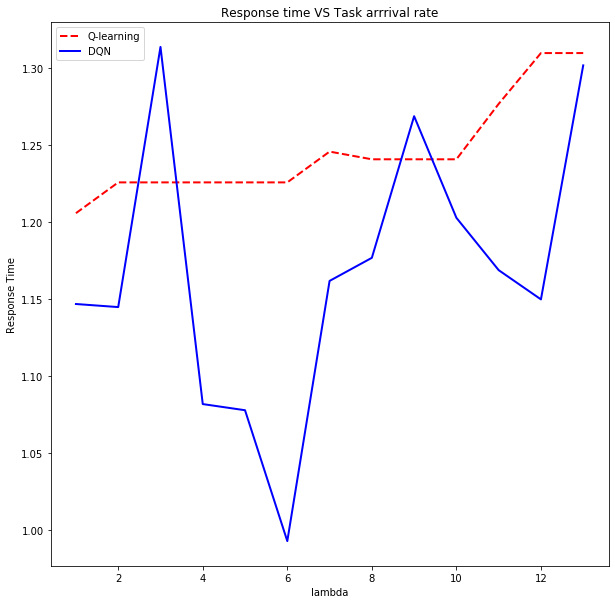

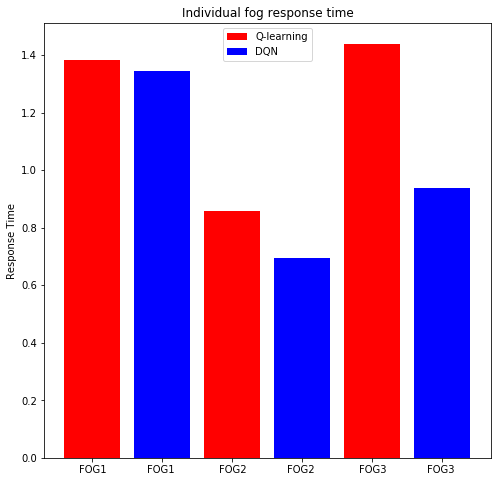

In [26]:
print(rrt)
print(rrt2)

with open('Q_learning_time.txt','w') as f:
    for item in rrt:
        f.write("%s\n" % item)
        
with open('DQN_time.txt','w') as f:
    for item in rrt2:
        f.write("%s\n" % item)
        
with open('Q_learning_individual_time.txt','w') as f:
    for item in avg_response_time:
        f.write("%s\n" % item)
        
with open('DQN_tindividual_time.txt','w') as f:
    for item in avg_response_time2:
        f.write("%s\n" % item)
        

lamda1=[1,2,3,4,5,6,7,8,9,10,11,12,13] # 10,11,12 bad
lamda2=[1,2,3,4,5,6,7,8,9,10,11,12,13]

#lamda1=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # 10,11,12 bad
#lamda2=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

time1=[ rrt[0],rrt[1],rrt[2],rrt[3],rrt[4],rrt[5],rrt[6],rrt[7],rrt[8],rrt[9],rrt[10],rrt[11],rrt[12] ]
time2=[ rrt2[0],rrt2[1],rrt2[2],rrt2[3],rrt2[4],rrt2[5],rrt2[6],rrt2[7],rrt2[8],rrt2[9],rrt2[10],rrt2[11],rrt2[12] ]

#time1=[ rrt[0],rrt[1],rrt[2],rrt[3],rrt[4],rrt[5],rrt[6],rrt[7],rrt[8],rrt[9],rrt[10],rrt[11],rrt[12],rrt[13],rrt[14] ]
#time2=[ rrt2[0],rrt2[1],rrt2[2],rrt2[3],rrt2[4],rrt2[5],rrt2[6],rrt2[7],rrt2[8],rrt2[9],rrt2[10],rrt2[11],rrt2[12],rrt2[13],rrt2[14] ]

# time1=[ rrt[0],rrt[1],rrt[3],rrt[5],rrt[7],rrt[9],rrt[12] ]
# time2=[ rrt2[0],rrt2[1],rrt2[3],rrt2[5],rrt2[7],rrt2[9],rrt2[12] ]

plt.rcParams['figure.figsize'] = (10,10)

l1=plt.plot(lamda1,time1,linewidth=2,color='red',linestyle='dashed',label='Q-learning')
l2=plt.plot(lamda2,time2,linewidth=2,color='blue',label='DQN')

#plt.yticks([1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25])
#plt.yticks([1,1.5,2,2.5,3,3.5,4,5])
#plt.yticks([1,2,3,4,5,6])
#plt.yticks([1,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4,4.10])
plt.ylabel("Response Time")
plt.xlabel("lambda")
plt.title("Response time VS Task arrrival rate")
plt.legend()

#plt.savefig()
#plt.figure(figsize=(4,2))

plt.show()

plt.rcParams['figure.figsize'] = (8,8)

plt.bar(['FOG1'],[avg_response_time[15]], color = ['red'],label='Q-learning')
plt.bar(['FOG1 '],[avg_response_time2[15]], color = ['blue'],label='DQN')
plt.bar(['FOG2'],[avg_response_time[16]], color = ['red'])
plt.bar(['FOG2 '],[avg_response_time2[16]], color = ['blue'])
plt.bar(['FOG3'],[avg_response_time[17]], color = ['red'])
plt.bar(['FOG3 '],[avg_response_time2[17]], color = ['blue'])

# plt.bar(['FOG1'],[avg_response_time[18]], color = ['red'],label='Random')
# plt.bar(['FOG1 '],[avg_response_time2[18]], color = ['blue'],label='Q-learning')
# plt.bar(['FOG2'],[avg_response_time[19]], color = ['red'])
# plt.bar(['FOG2 '],[avg_response_time2[19]], color = ['blue'])
# plt.bar(['FOG3'],[avg_response_time[20]], color = ['red'])
# plt.bar(['FOG3 '],[avg_response_time2[20]], color = ['blue'])

# plt.bar(['FOG1'],[avg_response_time[21]], color = ['red'],label='Q-learning')
# plt.bar(['FOG1 '],[avg_response_time2[21]], color = ['blue'],label='DQN')
# plt.bar(['FOG2'],[avg_response_time[22]], color = ['red'])
# plt.bar(['FOG2 '],[avg_response_time2[22]], color = ['blue'])
# plt.bar(['FOG3'],[avg_response_time[23]], color = ['red'])
# plt.bar(['FOG3 '],[avg_response_time2[23]], color = ['blue'])



#plt.yticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5])
#plt.yticks([0,1,2,3,4,5,6])
#plt.yticks([1,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4,4.10])
plt.ylabel("Response Time")
plt.title("Individual fog response time")
plt.legend()
#plt.savefig()

plt.show()

In [ ]:
1.335, 1.277, 1.28, 1.299, 1.34, 1.417, 1.542, 1.649, 1.669, 1.746, 1.738, 1.796, 1.869, 1.849, 1.894]
[1.28, 1.209, 1.308, 1.381, 1.588, 1.455, 1.741, 1.31, 1.551, 1.833, 1.621, 1.567, 1.509, 1.58, 1.699]




1.335, 1.277, 1.28, 1.299, 1.34, 1.417, 1.542, 1.649, 1.669, 1.746, 1.738, 1.796, 1.869, 1.849, 1.894]
[1.395, 1.356, 1.336, 1.447, 1.349, 1.555, 1.637, 1.636, 1.564, 1.582, 1.684, 1.657, 1.65, 1.66, 1.419]


Image('G:/THESIS/Figuress/c2fig2.png')

In [ ]:
Image('G:/THESIS/Figuress/c3fig1.png')


In [ ]:
Image('G:/THESIS/Figuress/c3fig2.png')

In [ ]:
Image('G:/THESIS/Figuress/c4fig1.png')

In [ ]:
Image('G:/THESIS/Figuress/c4fig2.png')

In [ ]:
Image('G:/THESIS/Figuress/c5fig1.png')

In [ ]:
Image('G:/THESIS/Figuress/c5fig2.png')

In [ ]:
env1 = simpy.Environment()    
server1 = simpy.Resource(env1, capacity=5)
server2 = simpy.Resource(env1, capacity=5)
server3 = simpy.Resource(env1, capacity=5)
rd.seed(2)

pipe1 = simpy.Store(env1)
pipe2 = simpy.Store(env1)
pipe3 = simpy.Store(env1)
pipe4 = simpy.Store(env1)
pipe5 = simpy.Store(env1)
statepipe = simpy.Store(env1)
currentpipe = simpy.Store(env1)

ms1=mobile(1)
ms2=mobile(2)
ms3=mobile(3)
ms4=mobile(4)

fog1 = Fog(0)
fog2 = Fog(1)
fog3=Fog(2)

fog1.Neighbour(fog2,fog3)
fog2.Neighbour(fog1,fog3)
fog3.Neighbour(fog1,fog2)


obj=Decision(1)
for i in range(N):
    env1.process(obj.decision1(env1,10,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe))
env1.run()

#print("after simulation q_table",q_table)
#print("after simulation present state and action",action_list)

fog1_count=obj.fog1_count
fog2_count=obj.fog2_count
fog3_count=obj.fog3_count
fog1_count=fog1_count-fog1.lost
fog2_count=fog2_count-fog2.lost
fog3_count=fog3_count-fog3.lost

print("lost",fog1.lost,fog2.lost,fog3.lost)
print("present count",fog1_count,fog2_count,fog3_count)
avgwaittime=sum(fog1.waitlist)/fog1_count
print("FOG-1 Average queueing time:", avgwaittime)
avgservicetime=sum(fog1.service_time)/fog1_count
print("FOG-1 Average service time:", avgservicetime)
avgsystemtime11=sum(fog1.response_time_list)/fog1_count
print("FOG-1 Average response time:", avgsystemtime)
avgenergy11=sum(fog1.energy_offloading)/fog1_count
print("FOG-1 Average Energy consumption:", avgenergy)
#print("No    response_time       reward")
#i=0
#while (i<N):
#   print("{}     {}     {}".format(i+1,fog2.response_time_list[i],fog2.reward_list[i]))
#  i+=1
#print("FOG-2 MAXIMUM REAWARD:", max(fog2.reward_list))
#print("FOG-2 total number of task in queue",fog2.Number_queue)
avgwaittime=sum(fog2.waitlist)/fog2_count
print("FOG-2 Average queueing time:", avgwaittime)
avgservicetime=sum(fog2.service_time)/fog2_count
print("FOG-2 Average service time:", avgservicetime)
avgsystemtime22=sum(fog2.response_time_list)/fog2_count
print("FOG-2 Average response time:", avgsystemtime)
avgenergy22=sum(fog2.energy_offloading)/fog2_count
print("FOG-2 Average Energy consumption:", avgenergy)

avgwaittime=sum(fog3.waitlist)/fog3_count
print("FOG-3 Average queueing time:", avgwaittime)
avgservicetime=sum(fog3.service_time)/fog3_count
print("FOG-3 Average service time:", avgservicetime)
avgsystemtime33=sum(fog3.response_time_list)/fog3_count
print("FOG-3 Average response time:", avgsystemtime)
avgenergy33=sum(fog3.energy_offloading)/fog3_count


